# 
Mały projekt 1: wizualizacja poziomu zanieczyszczeń (PM2.5)

Główny Inspektorat Ochrony Środowiska (GIOS) udostępnia dane o jakości powietrza w Polsce na stronie [https://powietrze.gios.gov.pl](https://powietrze.gios.gov.pl), tj. poziom stężenia pyłów PM2.5, PM10, SO2 i innych zanieczyszczeń. Dane te są szczególnie przydatne w analizach środowiskowych i zdrowotnych. W tym zadaniu interesują nas godzinne pomiary stężeń drobnego pyłu **PM2.5** (pyłu o średnicy poniżej 2.5 µm) w latach **2014, 2019 i 2024**. Pyły PM2.5 są one bardzo szkodliwe dla zdrowia, gdyż mogąc przenikać głęboko do układu oddechowego i krwiobiegu. Zadanie polega na przeprowadzeniu analizy danych wraz z opisami czynności oraz wykresami.

## Wymagania ogólne

- Rozwiązanie należy przygotować w formie **Jupyter Notebooka (`.ipynb`)**.  Rozwiązanie proszę przesłać przez Moodle’a.
- Wszystkie operacje czyszczenia i łączenia danych wykonaj **programistycznie**, bez ręcznej edycji plików.
- Do każdego punktu należy obowiązkowo dodać opis z analizą otrzymanych wyników.  
- Zadanie należy wykonać w wylosowanych parach. Obie osoby z pary przesyłają **identyczne pliki** i dodają na początku notebooka opis swojego wkładu.
- Ocena jest wspólna dla pary, a nie indywidualna.

## Dane wejściowe i metadane

- Każdy rok to archiwum ZIP dostępne pod adresem [https://powietrze.gios.gov.pl/pjp/archives/](https://powietrze.gios.gov.pl/pjp/archives/).
- Wewnątrz znajdują się pliki Excel, np. `2024_PM25_1g.xlsx`.
- Poniższa funkcja `download_gios_archive` pozwala odczytać odpowiedni zbior danych; resztę danych pomijamy.
- Użyj pliku metadanych (dostępnego na tej samej stronie), aby zaktualizować **kody stacji** (część stacji mogła w międzyczasie zmienić nazwę). W metadanych znajdziesz odpowiednie kolumny.

## Zadania

### 1. Wczytanie i czyszczenie danych

Wczytaj dane dla lat **2014, 2019 i 2024**, oczyścić je z niepotrzebnych wierszy oraz ujednolić ich format. Zaktualizuj stare kody stacji zgodnie z metadanymi. Pozostaw tylko stacje występujące we wszystkich trzech latach. Informacje o stacjach pomiarowych warto uzupełnić o miejscowości dostępne w metadanych, np. za pomocą MultiIndex: (miejscowość, kod stacji). Pomiary dokonane o północy (00:00:00) powinny być potraktowane jako dotyczące poprzedniego dnia. Połącz dane z trzech lat w jeden `DataFrame` i zapisz do pliku.

### 2. Średnie miesięczne + trend dla miast

Oblicz średnie miesięczne stężenie PM2.5 dla każdej stacji i roku. Dla **Warszawy** i **Katowic**, po uśrednieniu po wszystkich stacjach z tych miast, narysuj wykres liniowy pokazujący trend średnich miesięcznych wartości PM2.5 w 2014 i 2024 roku. Oś X - miesiące (1-12); oś Y - średnia wartość PM2.5; 4 linie trendu. Dołącz opis i interpretację obserwowanych różnic.

### 3. Heatmapa miesięcznych średnich

Dla każdej miejscowości przedstaw heatmapę średnich miesięcznych stężeń PM2.5 w latach lat 2014, 2019 i 2024 (oś X – miesiąc, oś Y – rok). Uśrednij wartości po wszystkich stacjach w danej miejscowości. Każdy panel (facet) ma odpowiadać jednej miejscowości. Dołącz interpretację obserwowanych wyników.

### 4. Dni z przekroczeniem normy (WHO)

Dla każdej stacji i roku policz liczbę dni, w których wystąpiło przekroczenie dobowej normy stężenia PM2.5, czyli 15 µg/m³ (źródło: [https://airscan.org/new-who-air-quality-guidelines-2021/](https://airscan.org/new-who-air-quality-guidelines-2021/)). Znajdź 3 stacje z najmniejszą i 3 stacje z największą liczbą dni z przekroczeniem normy dobowej w 2024 roku. Dla tych 6 stacji narysuj *grouped barplot*, gdzie oś X – stacje, oś Y – liczba dni z przekroczeniem, kolor – rok (2014, 2019, 2024). Dołącz opis i interpretację obserwowanych różnic.

## Dodatkowe wymagania i sugestie

- Notebook powinien zawierać *sanity checks*, np.:
  - liczba stacji w każdym pliku,
  - liczba dni w każdym roku,  
  - kilka przykładowych mapowań kodów stacji,  
- Wszystkie wykresy powinny mieć tytuły, legendy i krótki opis interpretacji.
- Zachęcamy do weryfikacji kodu napisanego przez drugą osobę, gdyż ocena jest wspólna.
- Można wykorzystać dowolne poznane biblioteki do analizy i wizualizacji danych w Pythonie.

## Kryteria oceny

- Zadanie 1: 3 pkt
- Zadanie 2: 2 pkt
- Zadanie 3: 1.5 pkt
- Zadanie 4: 2 pkt
- Jakość wyjaśnień, interpretacje, opis wkładu: 1.5 pkt



# Wkład:

## Zadanie 1: Amelia Bańkowska
## Zadanie 2: Amelia Bańkowska
## Zadanie 3: Paweł Galek
## Zadanie 4: Amelia Bańkowska

In [2]:
import pandas as pd
import requests
import zipfile
import io, os

# id archiwum dla poszczególnych lat
gios_archive_url = "https://powietrze.gios.gov.pl/pjp/archives/downloadFile/"
gios_url_ids = {2014: '302', 2019: '322', 2024: '582'}
gios_pm25_file = {2014: '2014_PM2.5_1g.xlsx', 2019: '2019_PM25_1g.xlsx', 2024: '2024_PM25_1g.xlsx'}

# funkcja do ściągania podanego archiwum
def download_gios_archive(year, gios_id, filename):
    # Pobranie archiwum ZIP do pamięci
    url = f"{gios_archive_url}{gios_id}"
    response = requests.get(url)
    response.raise_for_status()  # jeśli błąd HTTP, zatrzymaj
    
    # Otwórz zip w pamięci
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        # znajdź właściwy plik z PM2.5
        if not filename:
            print(f"Błąd: nie znaleziono {filename}.")
        else:
            # wczytaj plik do pandas
            with z.open(filename) as f:
                try:
                    df = pd.read_excel(f, header=None)
                except Exception as e:
                    print(f"Błąd przy wczytywaniu {year}: {e}")
    return df

# Przykladowe użycie
df2024 = download_gios_archive(2024, gios_url_ids[2024], gios_pm25_file[2024])
df2019 = download_gios_archive(2019, gios_url_ids[2019], gios_pm25_file[2019])
df2014 = download_gios_archive(2014, gios_url_ids[2014], gios_pm25_file[2014])

/opt/miniconda3/envs/zpp/lib/python3.10/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [3]:
# Sprawdzam jak wyglada moja data frame
df2024.head(10)

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,96
0,Nr,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,96
1,Kod stacji,DsChojnowMalMOB,DsJelGorOgin,DsKlodzSzkol,DsKudowaSzkoMOB,DsWrocAlWisn,DsWrocWybCon,KpBydPlPozna,KpBydWarszaw,KpNaklWawrzy,...,WmElkStadion,WmOlsPuszkin,WpKaliSawick,WpKoscianMayMOB,WpPoznDabrow,WpPoznSzwajc,ZpDabkiSztorMOB,ZpKolZolkiew,ZpSzczAndrze,ZpSzczPilsud
2,Wskaźnik,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,...,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5
3,Czas uśredniania,1g,1g,1g,1g,1g,1g,1g,1g,1g,...,1g,1g,1g,1g,1g,1g,1g,1g,1g,1g
4,Jednostka,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,...,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3
5,Kod stanowiska,DsChojnowMalMOB-PM2.5-1g,DsJelGorOgin-PM2.5-1g,DsKlodzSzkol-PM2.5-1g,DsKudowaSzkoMOB-PM2.5-1g,DsWrocAlWisn-PM2.5-1g,DsWrocWybCon-PM2.5-1g,KpBydPlPozna-PM2.5-1g,KpBydWarszaw-PM2.5-1g,KpNaklWawrzy-PM2.5-1g,...,WmElkStadion-PM2.5-1g,WmOlsPuszkin-PM2.5-1g,WpKaliSawick-PM2.5-1g,WpKoscianMayMOB-PM2.5-1g,WpPoznDabrow-PM2.5-1g,WpPoznSzwajc-PM2.5-1g,ZpDabkiSztorMOB-PM2.5-1g,ZpKolZolkiew-PM2.5-1g,ZpSzczAndrze-PM2.5-1g,ZpSzczPilsud-PM2.5-1g
6,2024-01-01 01:00:00,NaN,30.8,53.5,NaN,94,58.3,28.5,110.9,96.8,...,48.6,37.4,69.9,90.2,41.3,67.9,26.5,63.9,49.9,57.6
7,2024-01-01 02:00:00,NaN,30.2,61.3,NaN,44.8,44.8,73.9,39.5,37,...,12.8,18.8,57.1,55.4,38.4,88.7,26.8,33.5,15.4,24.6
8,2024-01-01 03:00:00,NaN,22.4,56.1,NaN,20.2,30.5,66.5,39.6,43.6,...,11,19,56,46.1,25.8,84.6,24.9,32.9,14.3,21.7
9,2024-01-01 04:00:00,NaN,11.2,27.6,NaN,14.7,18.5,66.8,36.2,42.6,...,10,18.7,44.1,26.9,16.3,75.8,26.4,32.6,17,20.1


In [4]:
df2019.head(10)

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,Nr,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
1,Kod stacji,DsDusznikMOB,DsJaworMOB,DsJelGorOgin,DsWrocAlWisn,DsWrocWybCon,KpBydPlPozna,KpMogiNowMOB,KpToruDziewu,KpWloclOkrze,...,SlBielPartyz,SlKatoKossut,SlZlotPotLes,WmElbBazynsk,WmGoldUzdrowMOB,WmOlsPuszkin,WpKaliSawick,ZpSzczAndr01,ZpSzczBudzWosMOB,ZpSzczPils02
2,Wskaźnik,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,...,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5
3,Czas uśredniania,1g,1g,1g,1g,1g,1g,1g,1g,1g,...,1g,1g,1g,1g,1g,1g,1g,1g,1g,1g
4,Jednostka,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,...,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3,ug/m3
5,Kod stanowiska,DsDusznikMOB-PM2.5-1g,DsJaworMOB-PM2.5-1g,DsJelGorOgin-PM2.5-1g,DsWrocAlWisn-PM2.5-1g,DsWrocWybCon-PM2.5-1g,KpBydPlPozna-PM2.5-1g,KpMogiNowMOB-PM2.5-1g,KpToruDziewu-PM2.5-1g,KpWloclOkrze-PM2.5-1g,...,SlBielPartyz-PM2.5-1g,SlKatoKossut-PM2.5-1g,SlZlotPotLes-PM2.5-1g,WmElbBazynsk-PM2.5-1g,WmGoldUzdrowMOB-PM2.5-1g,WmOlsPuszkin-PM2.5-1g,WpKaliSawick-PM2.5-1g,ZpSzczAndr01-PM2.5-1g,ZpSzczBudzWosMOB-PM2.5-1g,ZpSzczPils02-PM2.5-1g
6,2019-01-01 01:00:00,33.4053,51.3878,118.773,102.09,107.061,64.1177,NaN,24.003,51.317,...,110.199,76.7306,26.3444,34.3706,14.9449,40.9183,75.2,NaN,NaN,73.935
7,2019-01-01 02:00:00,13.8028,28.4995,110.064,63.6111,55.9187,43.8401,NaN,33.6542,30.698,...,73.4132,54.4664,19.0619,23.1494,10.742,25.9358,47.9076,NaN,NaN,11.7883
8,2019-01-01 03:00:00,9.94056,11.1206,107.941,48.354,41.3488,22.8383,NaN,13.603,28.262,...,50.2355,50.4599,43.7717,21.0711,12.0391,24.5725,22.8309,5.57095,NaN,8.69917
9,2019-01-01 04:00:00,6.75889,5.57358,94.5489,34.6621,29.8697,20.1829,NaN,17.4302,26.522,...,37.5872,34.809,64.0139,21.1671,13.1849,20.6336,20.59,5.77369,NaN,5.96861


In [5]:
df2014.head(10)

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,Kod stacji,DsWrocWisA,KpAirpWiktorowo,KpBydgPlPozn,KpBydgWarszawska,KpTorunDziewulsk,LdLodzWIOSACzernik,LdZgierzWIOSAMielcza,LuZgoraWIOS_AUT,MpKrakowWIOSAKra6117,...,SkMalogCemen3,SkPolanRuszcz,SlGliwiGliw_mewy,SlKatowKato_kossu,SlZlotyJano_lesni,WmOlsztyWIOS_Puszkin,WpWKP001,WpWKPKalisz007/10,ZpSzczecin001,ZpSzczecin002
1,Wskaźnik,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,...,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5,PM2.5
2,Czas uśredniania,1g,1g,1g,1g,1g,1g,1g,1g,1g,...,1g,1g,1g,1g,1g,1g,1g,1g,1g,1g
3,2014-01-01 01:00:00,152,104.56,116.214424,140.857376,52.4172,81.029259,119.696114,NaN,104,...,34.12,56.54,188,104,32,84.121582,56.1,NaN,105.489,109
4,2014-01-01 02:00:00,137,94.3,NaN,121.629723,NaN,210.36467,70.337502,NaN,104,...,34.61,35.93,130,107,39,75.444382,55.2,82.5,149.797,118
5,2014-01-01 03:00:00,129,102.48,NaN,59.189041,46.5652,66.425789,40.915695,NaN,91,...,33.58,34.36,138,114,43,34.427513,49.9,83,86.9602,120
6,2014-01-01 04:00:00,129,102.32,NaN,58.038334,45.8128,53.999668,37.817917,NaN,89,...,31.37,35.21,171,108,42,32.742474,52,73.1,74.8762,104
7,2014-01-01 05:00:00,105,88.73,NaN,59.658134,45.8128,52.23967,38.814861,NaN,83,...,32.27,35.54,163,88,40,32.714367,63.4,74.9,61.9866,96
8,2014-01-01 06:00:00,92,83.68,NaN,58.109863,44.4752,56.738743,40.452362,NaN,81,...,32.28,34.78,152,77,45,29.906473,61.8,77.4,51.5138,87
9,2014-01-01 07:00:00,92,93.46,62.139446,56.460609,43.5556,54.783894,40.300835,NaN,77,...,31.87,33.03,126,85,46,28.310535,53.2,80.8,58.7642,78


In [6]:
# Liczba wierszy i kolumn
print(f'Liczba kolumn: {df2024.shape[1]} i wierszy: {df2024.shape[0]} rok 2024.')
print(f'Liczba kolumn: {df2019.shape[1]} i wierszy: {df2019.shape[0]} rok 2019.')
print(f'Liczba kolumn: {df2014.shape[1]} i wierszy: {df2014.shape[0]} rok 2014.')

Liczba kolumn: 97 i wierszy: 8790 rok 2024.
Liczba kolumn: 64 i wierszy: 8766 rok 2019.
Liczba kolumn: 36 i wierszy: 8763 rok 2014.


In [7]:
def clean_data(df):
    df=df.set_index(0)
    
    # Sprawdzamy, czy wiersze istnieją
    if {'Kod stanowiska','Jednostka','Nr'}.issubset(df.index): # Widzę, że w roku 2014 nie ma takich kolumn
        df = df.drop(['Wskaźnik','Kod stanowiska','Czas uśredniania','Jednostka','Nr'])
    else:
        df = df.drop(['Wskaźnik','Czas uśredniania'])
    
    # Ustawiam pierwszy wiersz jako nazwy kolumn
    df.columns=df.iloc[0,:]
    # Usuwam pierwszy wiersz, bo został użyty jako nagłówek
    df = df.iloc[1:]
    # Konwertuję indeks na typ datetime (data w indeksie)
    df.index = pd.to_datetime(df.index) # Zmieniam format
    
    # Przesunięcie dnia
    df.index = [
    idx - pd.Timedelta(days=1) if idx.hour == 0 else idx
    for idx in df.index]
    
    df.index.name ="Data poboru danych"
    
    return df


df2024_clean=clean_data(df2024)
df2014_clean=clean_data(df2014)
df2019_clean=clean_data(df2019)

In [8]:
# Liczba wierszy i kolumn po czyszczeniu danych
print(f'Liczba kolumn: {df2024_clean.shape[1]} i wierszy: {df2024_clean.shape[0]} rok 2024.')
print(f'Liczba kolumn: {df2019_clean.shape[1]} i wierszy: {df2019_clean.shape[0]} rok 2019.')
print(f'Liczba kolumn: {df2014_clean.shape[1]} i wierszy: {df2014_clean.shape[0]} rok 2014.')

Liczba kolumn: 96 i wierszy: 8784 rok 2024.
Liczba kolumn: 63 i wierszy: 8760 rok 2019.
Liczba kolumn: 35 i wierszy: 8760 rok 2014.


In [9]:
df2024_clean.head()

Kod stacji,DsChojnowMalMOB,DsJelGorOgin,DsKlodzSzkol,DsKudowaSzkoMOB,DsWrocAlWisn,DsWrocWybCon,KpBydPlPozna,KpBydWarszaw,KpNaklWawrzy,KpSwiecJPawlMOB,...,WmElkStadion,WmOlsPuszkin,WpKaliSawick,WpKoscianMayMOB,WpPoznDabrow,WpPoznSzwajc,ZpDabkiSztorMOB,ZpKolZolkiew,ZpSzczAndrze,ZpSzczPilsud
Data poboru danych,,,,,,,,,,,,,,,,,,,,,
2024-01-01 01:00:00,NaN,30.8,53.5,NaN,94,58.3,28.5,110.9,96.8,54.7,...,48.6,37.4,69.9,90.2,41.3,67.9,26.5,63.9,49.9,57.6
2024-01-01 02:00:00,NaN,30.2,61.3,NaN,44.8,44.8,73.9,39.5,37,23.2,...,12.8,18.8,57.1,55.4,38.4,88.7,26.8,33.5,15.4,24.6
2024-01-01 03:00:00,NaN,22.4,56.1,NaN,20.2,30.5,66.5,39.6,43.6,25.3,...,11,19,56,46.1,25.8,84.6,24.9,32.9,14.3,21.7
2024-01-01 04:00:00,NaN,11.2,27.6,NaN,14.7,18.5,66.8,36.2,42.6,26,...,10,18.7,44.1,26.9,16.3,75.8,26.4,32.6,17,20.1
2024-01-01 05:00:00,NaN,22.5,25.8,NaN,17.2,18,58.4,35.6,41.4,26.8,...,8.4,19,40.5,22.2,12.6,50.8,28.7,31,27.2,19.7


In [10]:
# Pobieram metadane
meta_url = "https://powietrze.gios.gov.pl/pjp/archives/downloadFile/584"  
meta_response = requests.get(meta_url)
meta_response.raise_for_status()

# Zapisujemy plik lokalnie
with open("metadane.xlsx", "wb") as f:
    f.write(meta_response.content)

print("Plik pobrany i zapisany")

Plik pobrany i zapisany


In [11]:
metadane=pd.read_excel("metadane.xlsx")

In [12]:
cols = list(metadane.columns)  # Pobieramy listę kolumn
# Zmiana nazwy kolumny
cols[4] = 'Stary kod'          
metadane.columns = cols         # Przypisujemy z powrotem

In [13]:
metadane = metadane.dropna(subset=['Stary kod'])

# Dzielę komórki zawierające wiele starych kodów na listy (oddzielone przecinkiem)
metadane['Stary kod'] = metadane['Stary kod'].str.split(', ')

# Rozwijam listy tak, aby każdy stary kod był w osobnym wierszu
metadane_exploded = metadane.explode('Stary kod')

mapping=dict(zip(metadane_exploded['Stary kod'],metadane_exploded['Kod stacji']))

In [14]:
# Sprawdzam moje mapowanie

set2014=list(df2014_clean.columns)
set_meta=list(metadane_exploded['Stary kod'])

set_all=set(set2014)&set(set_meta)

# Nazwy tych kolumn powinny ulec zmienia po mapowaniu
print(set2014)

['DsWrocWisA', 'KpAirpWiktorowo', 'KpBydgPlPozn', 'KpBydgWarszawska', 'KpTorunDziewulsk', 'LdLodzWIOSACzernik', 'LdZgierzWIOSAMielcza', 'LuZgoraWIOS_AUT', 'MpKrakowWIOSAKra6117', 'MpKrakowWIOSBuja6119', 'MpKrakowWIOSBulw6118', 'MzLegionZegIMGW', 'MzPlockReja', 'MzRadomTochter', 'MzSiedlceKonar', 'MzWarNiepodKom', 'MzWarszUrsynow', 'MzZyrardRoosevel', 'OpKkozle1a', 'PdBialyMiejska', 'PdSuwPulaski', 'PkPrzemyslWIOSGrunw', 'Pm.a08a', 'Pm.AM12.a', 'SkKielJagielWios', 'SkMalogCemen3', 'SkPolanRuszcz', 'SlGliwiGliw_mewy', 'SlKatowKato_kossu', 'SlZlotyJano_lesni', 'WmOlsztyWIOS_Puszkin', 'WpWKP001', 'WpWKPKalisz007/10', 'ZpSzczecin001', 'ZpSzczecin002']


In [15]:
print(df2014_clean['DsWrocWisA'].name)

# Nazwa powinna zostać zamieniona na DsWroAlWisn:
print(metadane_exploded['Kod stacji'][metadane_exploded['Stary kod'] == 'DsWrocWisA'])

DsWrocWisA
137    DsWrocAlWisn
Name: Kod stacji, dtype: object


In [16]:
df2024_clean.columns = df2024_clean.columns.map(lambda x: mapping.get(x, x))
df2019_clean.columns = df2019_clean.columns.map(lambda x: mapping.get(x, x))
df2014_clean.columns = df2014_clean.columns.map(lambda x: mapping.get(x, x))

In [17]:
if 'DsWrocWisA' in df2014_clean.columns:
    print("Kolumna istnieje")
else:
    print("Zła nazwa kolumny")

# czyli po mapowaniu nazwa tej kolumny się zmieniła

Zła nazwa kolumny


In [18]:
if 'DsWrocAlWisn' in df2014_clean.columns:
    print(df2014_clean['DsWrocAlWisn'].name)

DsWrocAlWisn


In [19]:
# Sprawdzam ile powinno być stacji po połaczeniu wszystkich lat w jeden data drame

def count_rows(df):
    return list(df.columns)

rows_2024=count_rows(df2024_clean)
rows_2019=count_rows(df2019_clean)
rows_2014=count_rows(df2014_clean)

all_stations=set(rows_2024)&set(rows_2019)&set(rows_2014)

#Sanity check
print(f'Przewidywana ilość stacji po połaczeniu: {len(all_stations)}')

Przewidywana ilość stacji po połaczeniu: 23


In [20]:
common_stations = df2024_clean.columns.intersection(df2019_clean.columns)
common_stations = common_stations.intersection(df2014_clean.columns)

df2024_common = df2024_clean[common_stations]
df2019_common = df2019_clean[common_stations]
df2014_common = df2014_clean[common_stations]

In [21]:
# Liczba wierszy i kolumn w data frame, po uzgodnieniu kolumn
print(f'Liczba kolumn: {df2024_common.shape[1]} i wierszy: {df2024_common.shape[0]} rok 2024.')
print(f'Liczba kolumn: {df2019_common.shape[1]} i wierszy: {df2019_common.shape[0]} rok 2019.')
print(f'Liczba kolumn: {df2014_common.shape[1]} i wierszy: {df2014_common.shape[0]} rok 2014.')

# Liczba kolumn jest taka sama.

Liczba kolumn: 23 i wierszy: 8784 rok 2024.
Liczba kolumn: 23 i wierszy: 8760 rok 2019.
Liczba kolumn: 23 i wierszy: 8760 rok 2014.


In [22]:
def make_multi_index(metadane, common_stations):
    filtered_metadane = metadane[metadane['Kod stacji'].isin(common_stations)]
    
    # Tworzymy listę krotek (Kod stacji, Miejscowość)
    station_city = list(zip(
        filtered_metadane['Kod stacji'],
        filtered_metadane['Miejscowość']
    ))
    
    # Tworzymy MultiIndex
    multi_index = pd.MultiIndex.from_tuples(
        station_city,
        names=['Kod stacji', 'Miejscowość']
    )
    
    return multi_index


for data in [df2024_common,df2014_common,df2019_common]:
    data.columns=make_multi_index(metadane,common_stations)

In [23]:
df_all_years = pd.concat([df2024_common, df2019_common, df2014_common])

In [24]:
# Liczba wierszy i kolumn po połaczeniu
print(f'Liczba kolumn: {df_all_years.shape[1]} i wierszy: {df_all_years.shape[0]}.')

Liczba kolumn: 23 i wierszy: 26304.


# Zadanie 2
Oblicz średnie miesięczne stężenie PM2.5 dla każdej stacji i roku. Dla Warszawy i Katowic, po uśrednieniu po wszystkich stacjach z tych miast, narysuj wykres liniowy pokazujący trend średnich miesięcznych wartości PM2.5 w 2014 i 2024 roku. Oś X - miesiące (1-12); oś Y - średnia wartość PM2.5; 4 linie trendu. Dołącz opis i interpretację obserwowanych różnic.

In [25]:
df_all=df_all_years.copy()

In [26]:
# Grupujemy kolumny po miesiacu (średnia miesięczna)

df_month=df_all.groupby([df_all.index.year,df_all.index.month]).mean()
df_month_2014_2024=df_month.loc[[2024,2014]]
df_month_2014_2024.index.names=['Rok','Miesiac']

df_month_2014_2024

# Wybieram odpowiednie miasta
df_waw = df_month_2014_2024.xs('Warszawa', level='Miejscowość', axis=1)
df_kat = df_month_2014_2024.xs('Katowice', level='Miejscowość', axis=1)

df_waw_mean = df_waw.mean(axis=1)

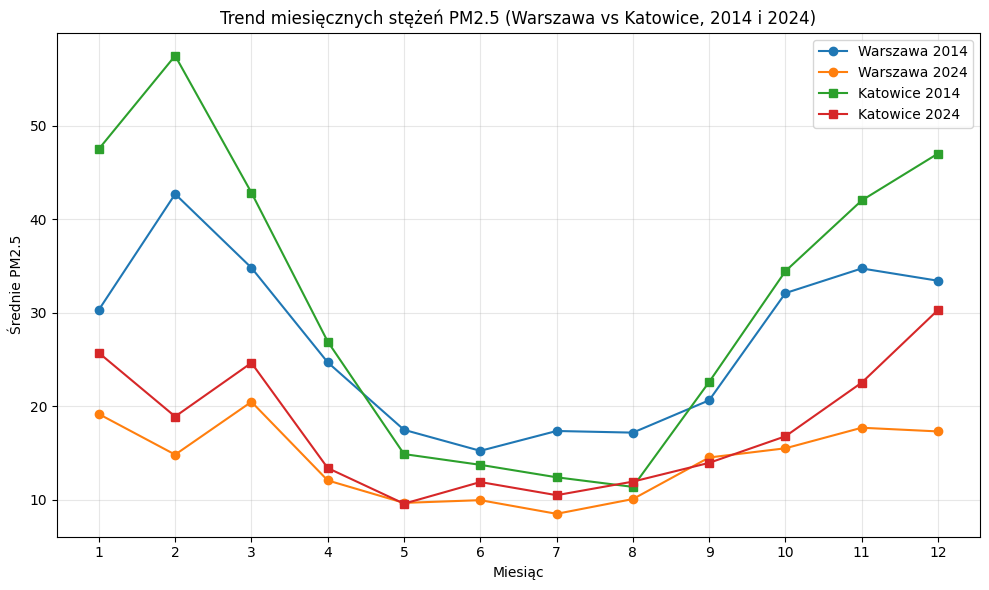

In [27]:
import matplotlib.pyplot as plt

# Wybieram odpowiedni rok i miasto
waw_2024 = df_waw_mean.xs(2024, level='Rok')
kat_2024 = df_kat.xs(2024, level='Rok')
waw_2014 =df_waw_mean.xs(2014, level='Rok')
kat_2014 = df_kat.xs(2014, level='Rok')

plt.figure(figsize=(10,6))

plt.plot(waw_2014.index, waw_2014.values, label="Warszawa 2014", marker='o')
plt.plot(waw_2024.index, waw_2024.values, label="Warszawa 2024", marker='o')
plt.plot(kat_2014.index, kat_2014.values, label="Katowice 2014", marker='s')
plt.plot(kat_2024.index, kat_2024.values, label="Katowice 2024", marker='s')

plt.xlabel("Miesiąc")
plt.ylabel("Średnie PM2.5")
plt.title("Trend miesięcznych stężeń PM2.5 (Warszawa vs Katowice, 2014 i 2024)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(range(1, 13))
plt.tight_layout()
plt.show()

# Opis wykresu oraz interpretacja

Wykres przedstawia średnie miesięczne stężenia PM2.5 w latach 2014 i 2024 dla stacji w Warszawie oraz Katowicach. 
Można zauważyć kilka wyraźnych trendów:
##### Sezonowość: stężenia PM2.5 są wyższe w okresie jesienno-zimowym (grudzień–luty), a niższe wiosną i latem.
##### Przyczyna zimowych pików: wzrost stężenia w miesiącach zimowych najprawdopodobniej wynika z rozpoczęcia sezonu grzewczego.
##### Porównanie lat: w 2024 roku obserwujemy nieco niższe średnie stężenia niż w 2014, co może świadczyć o poprawie jakości powietrza w wyniku ograniczeń emisji lub modernizacji źródeł ciepła.
##### Trend ogólny: niezależnie od roku, wartości PM2.5 systematycznie spadają wiosną i latem, a rosną jesienią i zimą.


# Zadanie 3

Dla każdej miejscowości przedstaw heatmapę średnich miesięcznych stężeń PM2.5 w latach lat 2014, 2019 i 2024 (oś X – miesiąc, oś Y – rok). Uśrednij wartości po wszystkich stacjach w danej miejscowości. Każdy panel (facet) ma odpowiadać jednej miejscowości. Dołącz interpretację obserwowanych wyników.

In [28]:
df_all = df_all_years.copy() # kopiowanie oryginalnego DataFrame by uniknąć modyfikacji oryginału

df_all.head() # pomocniczy podgląd danych

Kod stacji,DsWrocAlWisn,KpBydPlPozna,LdLodzCzerni,LdZgieMielcz,LuZielKrotka,MpKrakAlKras,MpKrakBulwar,MzLegZegrzyn,MzPlocMiReja,MzRadTochter,...,MzZyraRoosev,OpKKozBSmial,PkPrzemGrunw,PmGdaLeczkow,SlKatoKossut,SlZlotPotLes,WmOlsPuszkin,WpKaliSawick,ZpSzczAndrze,ZpSzczPilsud
Miejscowość,Wrocław,Bydgoszcz,Łódź,Zgierz,Zielona Góra,Kraków,Kraków,Legionowo,Płock,Radom,...,Żyrardów,Kędzierzyn-Koźle,Przemyśl,Gdańsk,Katowice,Złoty Potok,Olsztyn,Kalisz,Szczecin,Szczecin
Data poboru danych,,,,,,,,,,,,,,,,,,,,,
2024-01-01 01:00:00,94,28.5,43.2,68.4,38.3,68.6,42.1,45.7,59.9,90.7,...,65.6,48.1,10.4,27.9,75.8,25.2,37.4,69.9,49.9,57.6
2024-01-01 02:00:00,44.8,73.9,39.2,66.1,13.6,57.4,53,40.4,35.1,43.1,...,37.7,22,9.8,21.7,92.5,22.5,18.8,57.1,15.4,24.6
2024-01-01 03:00:00,20.2,66.5,39.2,49.2,15.9,56.3,71.7,44.1,35.3,35.3,...,38.4,21.6,12.1,21.1,100.6,28.8,19,56,14.3,21.7
2024-01-01 04:00:00,14.7,66.8,40.2,40.6,13.4,66.1,72.7,38.6,35.4,36.9,...,35.6,23.8,14.5,20.7,60.5,31.6,18.7,44.1,17,20.1
2024-01-01 05:00:00,17.2,58.4,40.2,40.7,13.1,63.7,67.6,33,37.6,38.4,...,33.1,27.9,16.8,19.8,60,22.5,19,40.5,27.2,19.7


In [29]:
df_month = df_all.groupby([df_all.index.year, df_all.index.month]).mean() # grupowanie po roku i miesiącu
df_month.index.names = ['Rok', 'Miesiąc']

df_month.head() # pomocniczy podgląd danych

Kod stacji   DsWrocAlWisn KpBydPlPozna LdLodzCzerni LdZgieMielcz LuZielKrotka  \
Miejscowość       Wrocław    Bydgoszcz         Łódź       Zgierz Zielona Góra   
Rok  Miesiąc                                                                    
2014 1          42.797037    30.616434    35.407387    31.518199    42.946602   
     2          38.649351    51.856173    45.704915    46.359747    33.748299   
     3             36.125    40.556041    35.259896    36.861373    37.276358   
     4          25.353659    19.772776    23.474251    18.767278    23.778929   
     5          14.963925     11.90341    16.407493    11.068347    12.545727   

Kod stacji   MpKrakAlKras MpKrakBulwar MzLegZegrzyn MzPlocMiReja MzRadTochter  \
Miejscowość        Kraków       Kraków    Legionowo        Płock        Radom   
Rok  Miesiąc                                                                    
2014 1          60.350806    47.241565    39.815343    31.855108    40.485457   
     2          86.708955    62.591045    62.753609    50.473512    53.218289   
     3          54.498652    39.900135    47.863719    31.600595    43.391626   
     4            34.7433    24.543417    27.777273    20.852646    27.699527   
     5          19.547718    14.522849    14.622747    12.079019    14.581354   

Kod stacji    ... MzZyraRoosev     OpKKozBSmial PkPrzemGrunw PmGdaLeczkow  \
Miejscowość   ...     Żyrardów Kędzierzyn-Koźle     Przemyśl       Gdańsk   
Rok  Miesiąc  ...                                                           
2014 1        ...    36.824947        42.847025    32.047507    15.574259   
     2        ...    55.307686        43.510433    51.465929    25.712251   
     3        ...    45.742247        45.567347    30.040347    15.098253   
     4        ...    26.113754        29.082759     20.73224    13.423333   
     5        ...    14.187658        16.551867    10.376133    10.499194   

Kod stacji   SlKatoKossut SlZlotPotLes WmOlsPuszkin WpKaliSawick ZpSzczAndrze  \
Miejscowość      Katowice  Złoty Potok      Olsztyn       Kalisz     Szczecin   
Rok  Miesiąc                                                                    
2014 1          47.531587     25.10559    25.550652    42.099015    32.280684   
     2          57.502297    32.390863    40.799969    52.429559    22.655796   
     3          42.855405    21.564371    24.921921    53.279132    26.832721   
     4          26.925608    14.539735    17.748875    32.493501    15.903186   
     5          14.893387     8.812585     13.58873    17.961618    10.925751   

Kod stacji   ZpSzczPilsud  
Miejscowość      Szczecin  
Rok  Miesiąc               
2014 1          32.398922  
     2          32.134731  
     3          37.271277  
     4          22.124302  
     5          12.351079  

[5 rows x 23 columns]

In [30]:
df_month.xs('Gdańsk', level='Miejscowość', axis=1)

Kod stacji   PmGdaLeczkow
Rok  Miesiąc             
2014 1          15.574259
     2          25.712251
     3          15.098253
     4          13.423333
     5          10.499194
     6           9.224652
     7          14.029542
     8          10.857903
     9          15.774861
     10         20.708748
     11         27.529722
     12         14.892473
2019 1                NaN
     2                NaN
     3                NaN
     4                NaN
     5                NaN
     6                NaN
     7           9.428528
     8          11.469635
     9           11.32575
     10         17.676947
     11         27.211042
     12         21.460477
2024 1          16.550539
     2          15.185036
     3          22.579217
     4          15.131198
     5          14.450538
     6          12.335188
     7           9.763795
     8          11.628857
     9           16.02227
     10         14.074832
     11         13.743611
     12         13.868102

In [31]:
df_month.xs('Siedlce', level='Miejscowość', axis=1)

Kod stacji   MzSiedKonars
Rok  Miesiąc             
2014 1          30.710269
     2          47.344554
     3          40.910263
     4          25.200014
     5          13.727911
     6           10.89375
     7          12.277581
     8          13.752298
     9          19.384659
     10         32.730767
     11         35.404681
     12         37.381438
2019 1          34.290953
     2          31.809182
     3          23.067634
     4          23.697977
     5          14.721895
     6          11.321144
     7           8.428871
     8          11.546317
     9          11.310292
     10         23.622981
     11         18.758244
     12         24.375197
2024 1          22.703514
     2          17.735776
     3          26.525707
     4           13.66064
     5           9.884767
     6           13.71958
     7                NaN
     8                NaN
     9                NaN
     10               NaN
     11               NaN
     12               NaN

### Niestety dane dla miast Gdańsk i Siedlce są wybrakowane
By nie przekłamywać wykresów takie pozostaną

In [32]:

df_city_month = df_month.groupby(level='Miejscowość', axis=1).mean() # grupowanie po mieście

df_city_month.head() # pomocniczy podgląd danych

/var/folders/db/bz5chhv95qs4p1sw6k437dm40000gn/T/ipykernel_62180/973072440.py:1: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_city_month = df_month.groupby(level='Miejscowość', axis=1).mean() # grupowanie po mieście


Miejscowość   Bydgoszcz     Gdańsk     Kalisz   Katowice     Kraków  \
Rok  Miesiąc                                                          
2014 1        30.616434  15.574259  42.099015  47.531587  53.796186   
     2        51.856173  25.712251  52.429559  57.502297  74.650000   
     3        40.556041  15.098253  53.279132  42.855405  47.199394   
     4        19.772776  13.423333  32.493501  26.925608  29.643359   
     5        11.903410  10.499194  17.961618  14.893387  17.035284   

Miejscowość   Kędzierzyn-Koźle  Legionowo    Olsztyn   Przemyśl      Płock  \
Rok  Miesiąc                                                                 
2014 1               42.847025  39.815343  25.550652  32.047507  31.855108   
     2               43.510433  62.753609  40.799969  51.465929  50.473512   
     3               45.567347  47.863719  24.921921  30.040347  31.600595   
     4               29.082759  27.777273  17.748875  20.732240  20.852646   
     5               16.551867  14.622747  13.588730  10.376133  12.079019   

Miejscowość       Radom    Siedlce   Szczecin   Warszawa    Wrocław  \
Rok  Miesiąc                                                          
2014 1        40.485457  30.710269  32.339803  30.329567  42.797037   
     2        53.218289  47.344554  27.395263  42.709664  38.649351   
     3        43.391626  40.910263  32.051999  34.821290  36.125000   
     4        27.699527  25.200014  19.013744  24.703460  25.353659   
     5        14.581354  13.727911  11.638415  17.487981  14.963925   

Miejscowość      Zgierz  Zielona Góra  Złoty Potok       Łódź   Żyrardów  
Rok  Miesiąc                                                              
2014 1        31.518199     42.946602    25.105590  35.407387  36.824947  
     2        46.359747     33.748299    32.390863  45.704915  55.307686  
     3        36.861373     37.276358    21.564371  35.259896  45.742247  
     4        18.767278     23.778929    14.539735  23.474251  26.113754  
     5        11.068347     12.545727     8.812585  16.407493  14.187658

In [33]:
matrix_dict = {} # słownik na macierze dla poszczególnych miast

for city in df_city_month.columns.values:

    matrix = df_city_month[city].unstack(level='Miesiąc') 
    matrix = matrix.reindex(index=[2014, 2019, 2024], columns=range(1, 13)) # reindeksacja, by mieć pewność, że wszystkie lata i miesiące są obecne

    matrix_dict[city] = matrix



matrix_dict["Warszawa"] # pomocniczy podgląd danych

Miesiąc,1,2,3,4,5,6,7,8,9,10,11,12
Rok,,,,,,,,,,,,
2014,30.329567,42.709664,34.821290,24.703460,17.487981,15.241010,17.364352,17.188444,20.648646,32.115304,34.749777,33.434030
2019,31.129459,29.895279,21.901896,21.839941,15.582090,13.351577,11.085776,12.725217,14.394046,23.860874,23.192062,23.106213
2024,19.174874,14.833942,20.484642,12.075045,9.672933,9.964408,8.503740,10.083477,14.528993,15.513990,17.711494,17.317070


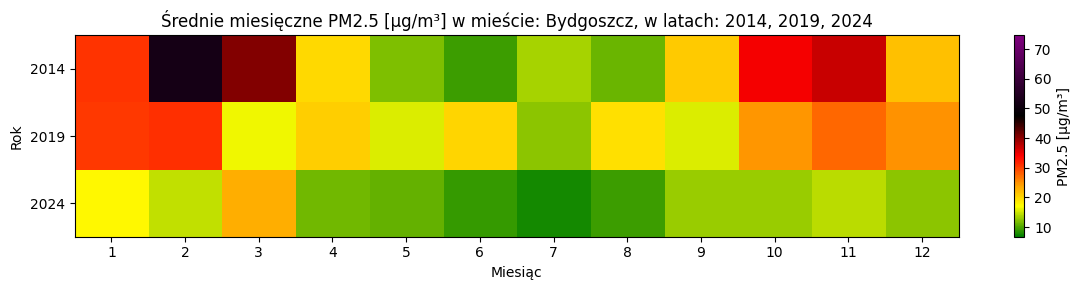

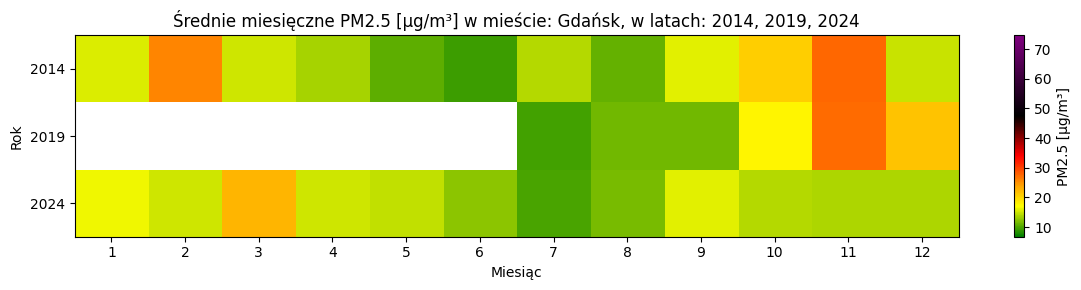

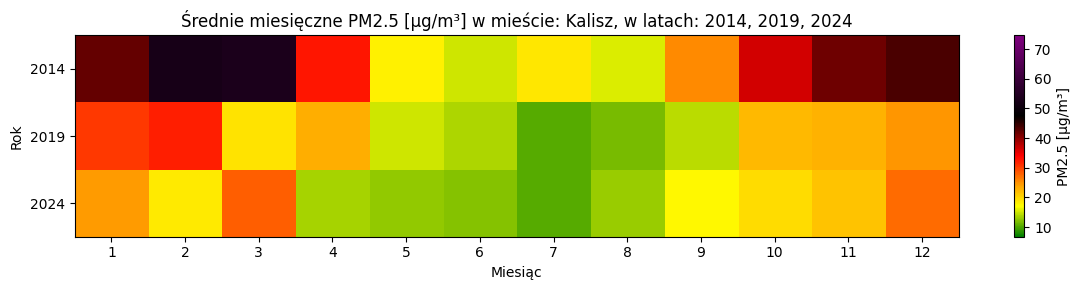

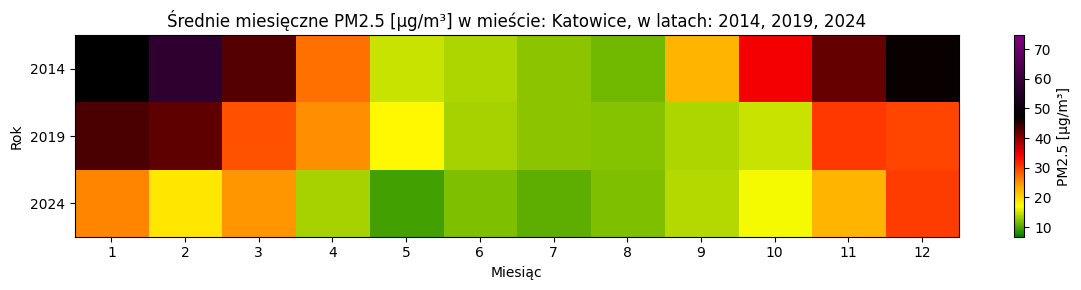

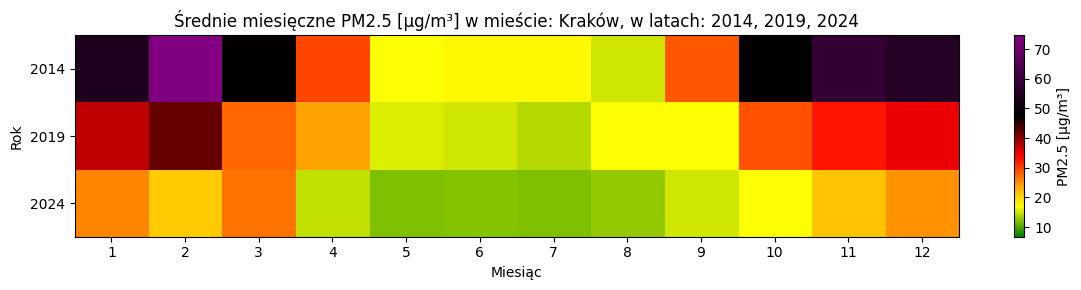

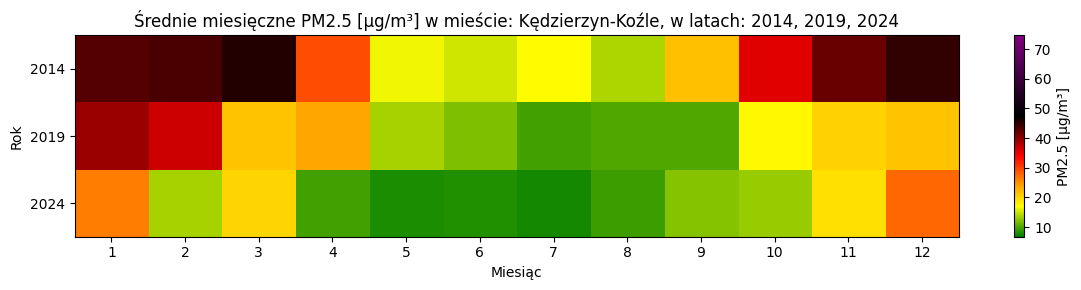

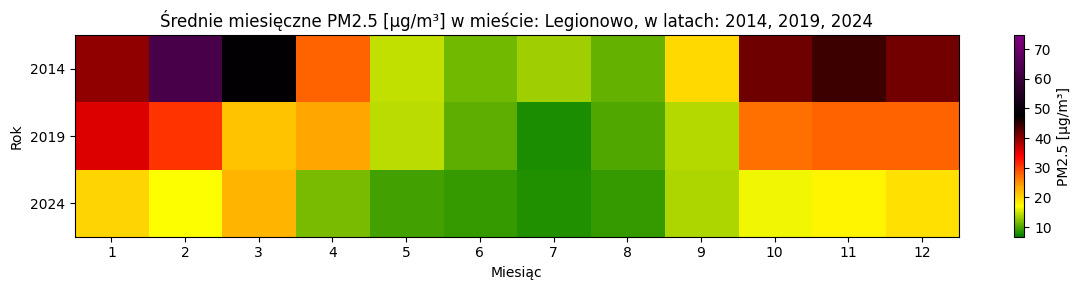

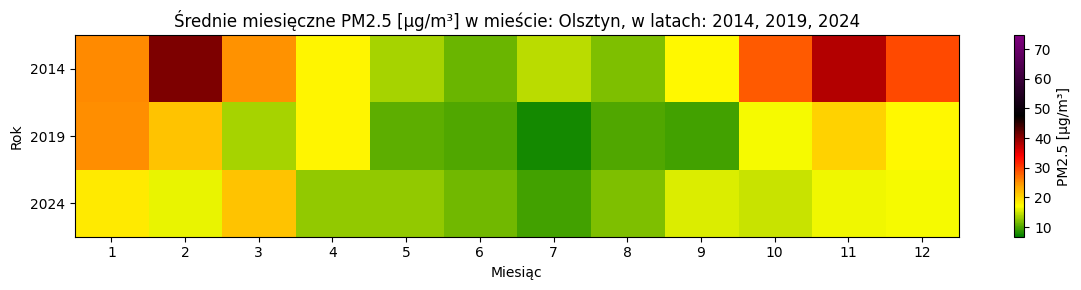

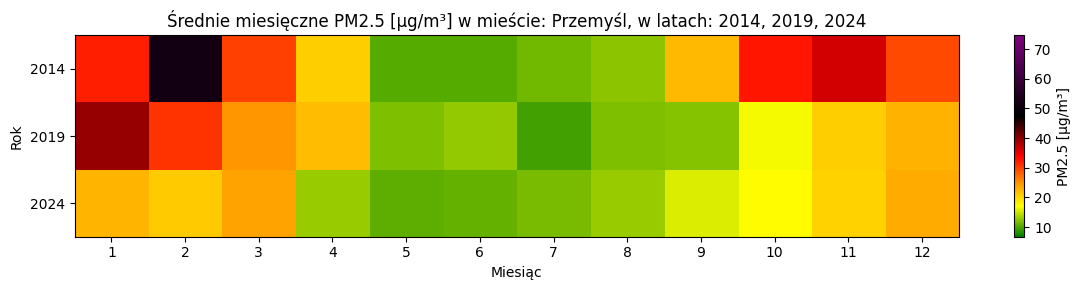

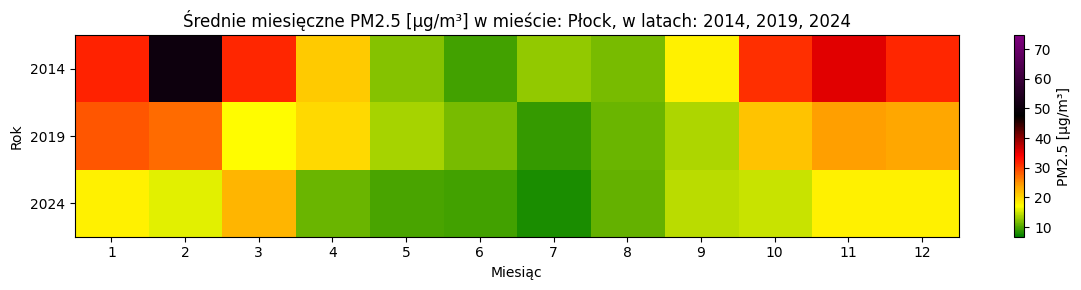

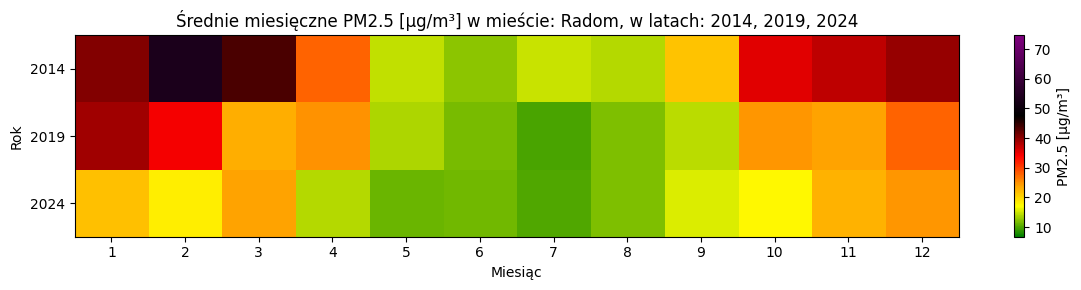

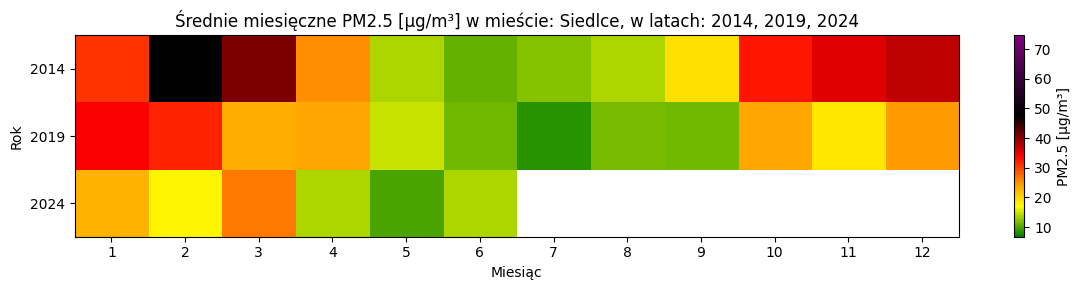

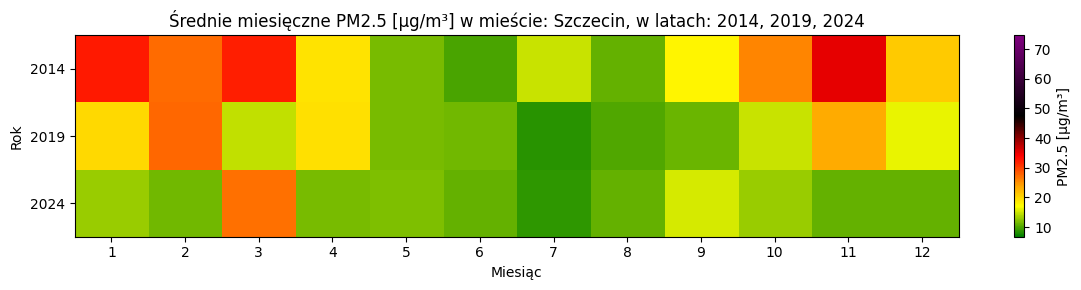

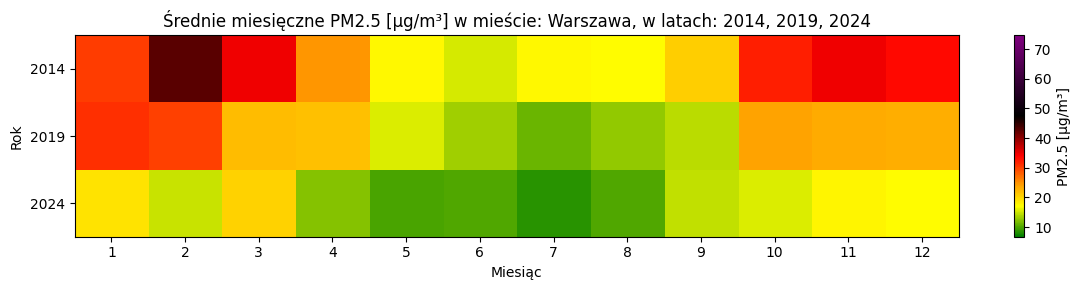

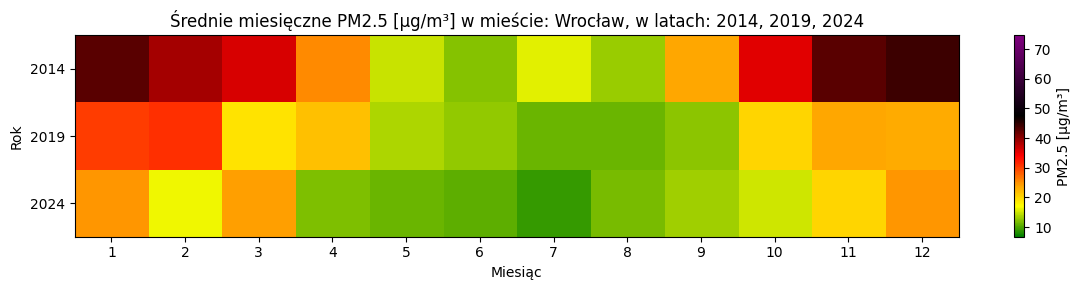

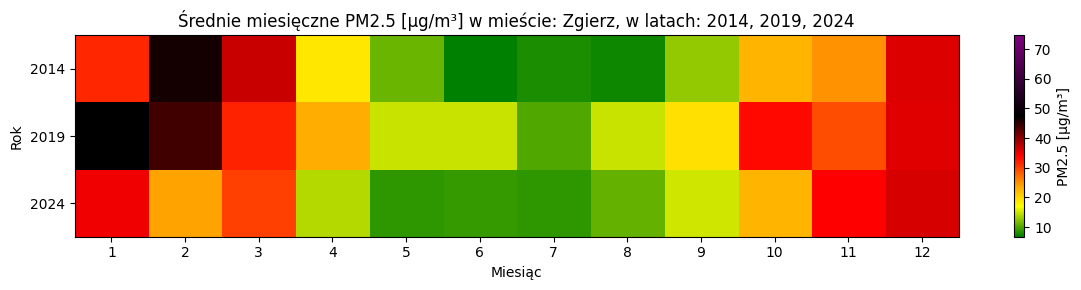

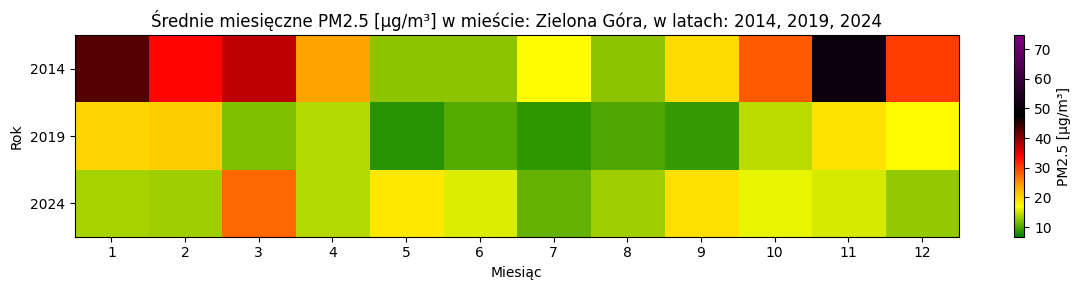

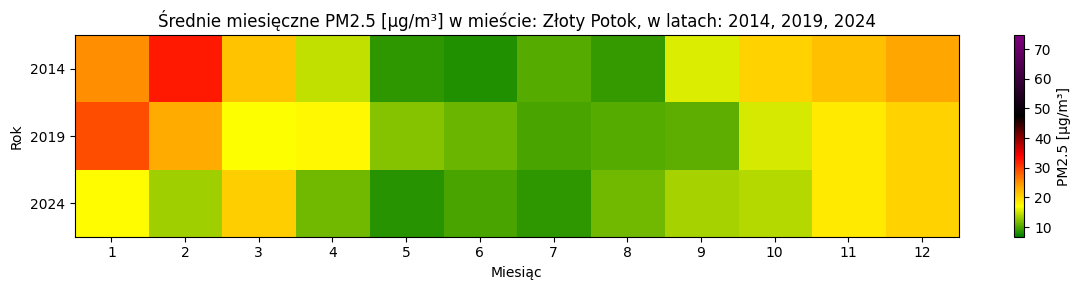

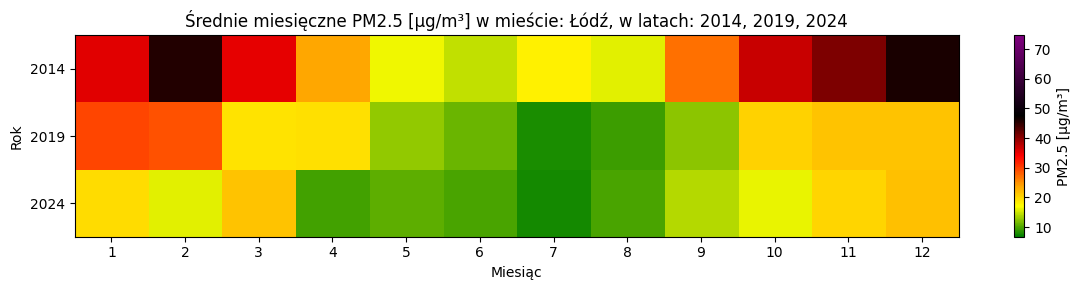

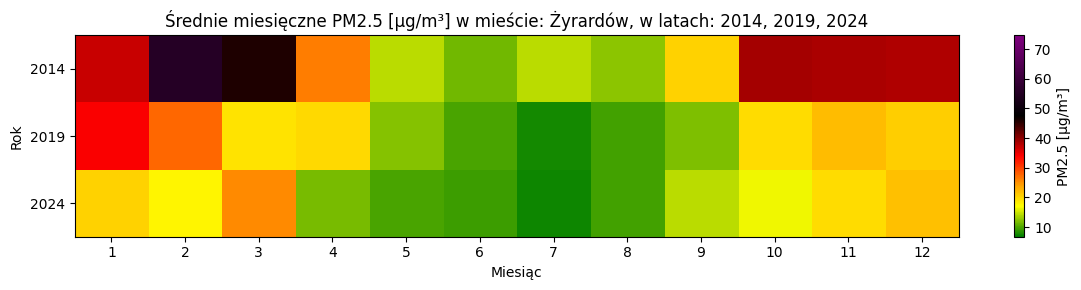

In [34]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

#ustalenie globalnego maksima i minima
global_min = df_city_month.min().min()
global_max = df_city_month.max().max()

# Custom mapa kolorów 
custom_cmap = LinearSegmentedColormap.from_list(
    "PM2.5",
    [
        (0.0,  "green"),   
        (0.15, "yellow"),   
        (0.25, "orange"),  
        (0.40, "red"),  
        (0.60, "black"),     
        (1.00, "purple"),   
    ]
)

for city in matrix_dict.keys(): 

    # ustalamy kształt wykresu 
    fig, ax = plt.subplots(figsize=(12, 3)) 
    
    # ukazanie danych jako obraz, stała mapa kolorów
    im = ax.imshow(matrix_dict[city], aspect='auto', cmap=custom_cmap, vmin=global_min, vmax=global_max) 
    
    # Podpisanie osi wykresu i nazwanie go 
    ax.set_title(f'Średnie miesięczne PM2.5 [µg/m³] w mieście: {city}, w latach: 2014, 2019, 2024')
    ax.set_xlabel('Miesiąc')
    ax.set_ylabel('Rok')
    
    # upewnienie się że oś x i y będzie wyglądać odpowiednio
    ax.set_xticks(range(12))
    ax.set_xticklabels(range(1, 13))
    ax.set_yticks(range(3))
    ax.set_yticklabels([2014, 2019, 2024])
    
    # colorbar 
    cbar = plt.colorbar(im, ax=ax, label='PM2.5 [µg/m³]')
    
    plt.tight_layout() # żeby uniknąć nakładania się elementów
    
    plt.show()

## Interpretacja

- Można zauważyć że średnia PM2.5 jest wyższa w sezonie jesienno zimowym, prawdopodobnie przez potrzebę ogrzewania domostw przez mieszkańców.

- Na ogół można stwierdzić że ilość PM2.5 wydzielanych spada wraz z czasem - modernizacja aparatur grzewczych i rozpowszechnienie czystszych źródeł energii

- Widoczne jest że w Gdańsku i Siedlcach brakuje danych z niektórych miesięcy

# Zadanie 4

Dla każdej stacji i roku policz liczbę dni, w których wystąpiło przekroczenie dobowej normy stężenia PM2.5, czyli 15 µg/m³ (źródło: https://airscan.org/new-who-air-quality-guidelines-2021/). Znajdź 3 stacje z najmniejszą i 3 stacje z największą liczbą dni z przekroczeniem normy dobowej w 2024 roku. Dla tych 6 stacji narysuj grouped barplot, gdzie oś X – stacje, oś Y – liczba dni z przekroczeniem, kolor – rok (2014, 2019, 2024). Dołącz opis i interpretację obserwowanych różnic.

In [35]:
# Dodaj kolumnę z datą (bez godziny)
df_all['data'] = df_all.index.date

# Oblicz średnią dzienną 
df_daily = df_all.groupby('data').mean()

# Sprawdzenie przekroczeń
exceed = df_daily > 15

# Grupowanie po roku (tylko istniejące lata)
days_exceeded= exceed.groupby(pd.DatetimeIndex(df_daily.index).year).sum()
days_exceeded.index.name = 'Rok'

In [36]:
# Filtrujemy tylko 2024
df2024 = days_exceeded.loc[2024]

# 3 stacje z najmniejszą liczbą dni
bottom3 = df2024.nsmallest(3)

# 3 stacje z największą liczbą dni
top3 = df2024.nlargest(3)

# Lista interesujących stacji
stations_of_interest = bottom3.index.tolist() + top3.index.tolist()
print(stations_of_interest)

# Wybieramy tylko interesujące stacje 
df_plot = days_exceeded[stations_of_interest]

df_plot_flat = df_plot.copy()
df_plot_flat.columns = [f"{kod}_{miasto}" for kod, miasto in df_plot_flat.columns]

df_plot_reset = df_plot_flat.reset_index()  # teraz 'Rok' jest kolumną

# Przekształcenie formatu
df_plot_long = df_plot_reset.melt(id_vars='Rok', var_name='station', value_name='days_exceeded')

[('ZpSzczAndrze', 'Szczecin'), ('MzSiedKonars', 'Siedlce'), ('MzWarWokalna', 'Warszawa'), ('LdZgieMielcz', 'Zgierz'), ('MpKrakAlKras', 'Kraków'), ('SlKatoKossut', 'Katowice')]


In [37]:
df2024

Kod stacji    Miejscowość     
DsWrocAlWisn  Wrocław             134
KpBydPlPozna  Bydgoszcz           108
LdLodzCzerni  Łódź                128
LdZgieMielcz  Zgierz              189
LuZielKrotka  Zielona Góra        145
MpKrakAlKras  Kraków              178
MpKrakBulwar  Kraków              152
MzLegZegrzyn  Legionowo           121
MzPlocMiReja  Płock               131
MzRadTochter  Radom               161
MzSiedKonars  Siedlce              79
MzWarAlNiepo  Warszawa            152
MzWarWokalna  Warszawa            102
MzZyraRoosev  Żyrardów            142
OpKKozBSmial  Kędzierzyn-Koźle    111
PkPrzemGrunw  Przemyśl            146
PmGdaLeczkow  Gdańsk              140
SlKatoKossut  Katowice            165
SlZlotPotLes  Złoty Potok         117
WmOlsPuszkin  Olsztyn             139
WpKaliSawick  Kalisz              163
ZpSzczAndrze  Szczecin             72
ZpSzczPilsud  Szczecin            130
Name: 2024, dtype: int64

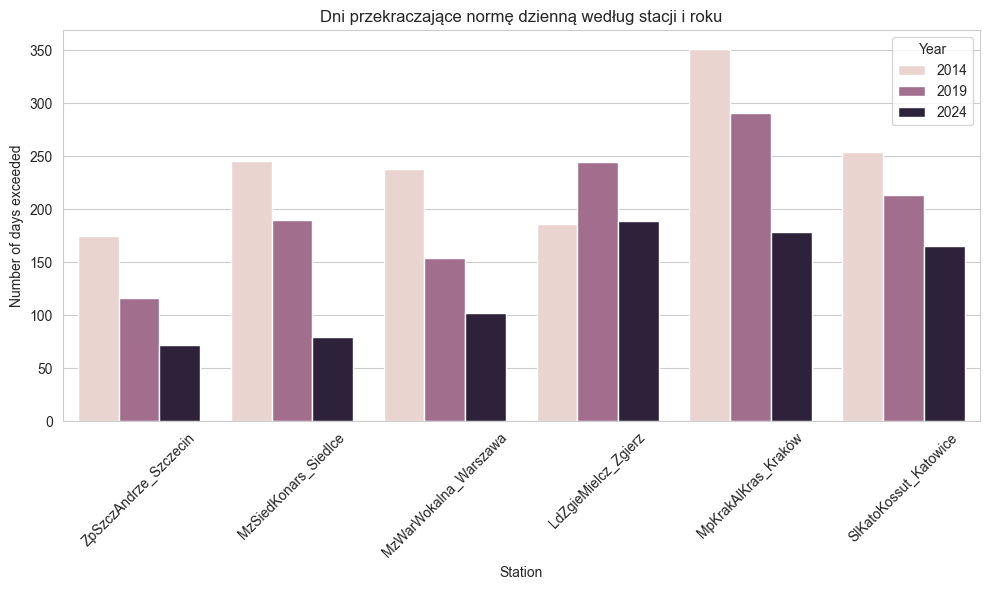

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
plt.figure(figsize=(10,6))

sns.barplot(data=df_plot_long, x='station', y='days_exceeded', hue='Rok')

plt.xlabel('Station')
plt.ylabel('Number of days exceeded')
plt.title('Dni przekraczające normę dzienną według stacji i roku')
plt.xticks(rotation=45)
plt.legend(title='Year')

plt.tight_layout()
plt.show()

# Opis i interpretacja

Wykres przedstawia liczbę dni z przekroczenie dobowej normy stężenia PM2.5 wybranych stacji w latach: 2014,2019 oraz 2024.
W roku 2014 wszystkie analizowane stacje odnotowały najwyższą liczbę dni z przekroczeniem dobowej normy, co wskazuje na niekorzystne warunki powietrza w tym okresie. W kolejnych latach 2019 i 2024 widać wyraźny spadek liczby dni z przekroczeniami, co może świadczyć o poprawie jakości powietrza w tych lokalizacjach.